---
title: Linear Convection with JAX - Part II
suptitle: Time Steppers with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

> In the previous tutorial, we broke up all of the pieces into abstract concepts. We also looked at how to jax-ify all the things by creating functions for all of the bits and pieces; ranging from the domain definition to the stepper. In this tutorial, we will repeat the same procedure but we will look again at the stepper. We will break the stepper apart and offset this to a library called `diffrax`. This will open up a world of different schemes for solving PDEs where we don't have to reinvent the wheel. With appropriate abstractions, we can instead focus on more interesting projects instead trying to do everything from scratch.

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import kernex as kex
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Recall: PDE - 1D Linear Convection

Let's continue from the previous tutorial. Recall, we are working with a 1D Linear Convection scheme:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
$$ (pde)

For the PDE {eq}`pde`, we are going to do a backwards difference discretization in space and a forwards in time. It is given by:

$$
u_{i}^{n+1} = u_{i}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (discretization_full)

## Recall: Jaxified Implementation

In the previous tutorial, we showed how to break this PDE into individual parts via *functions*. We identified the following parts and functions:

* Spatial Domain Definitions
* Temporal Domain Definitions
* Initial Condition Function
* Boundary Condition Function
* Right Hand Side (RHS)
* Step Function

I will go through each of these functions along with the notation we will use throughout this tutorial.

### Spatial Domain

We define our spatial discretization as:

$$
x \in \Omega \sub \mathbb{R}^{D}
$$ (spatial_d)

Where:

* $\mathbb{R}^D$ - the space of coordinates, e.g. Euclidean, Spherical, and the size, e.g. scalar, vector, etc
* $\Omega$ - the domain and discretization

For this problem our domain bounds are $[0.0, 2.0]$ and our time step is $\Delta x\sim 0.04$.


In [3]:
# spatial discretization
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)

# spatial grid
x_grid = np.linspace(xmin, xmax, nx)

# check dx
assert x_grid[1] - x_grid[0] == dx
print(f"Δx: {dx:.4f}")

Δx: 0.0408


### Temporal Domain

We define our temporal discretization as:

$$
t \in \mathcal{T} \sub \mathbb{R}^+
$$ (time_d)

where the space time coordinates are bounded by $\mathcal{T}=[0,T]$. For our problem, it is bounded between $[0.0, 0.5]$. Recall, the time step was calculated from the CFL condition given by

$$
\Delta t = \frac{\sigma\Delta x}{c} \leq 1
$$ (cfl_advection_dt)



In [4]:
# temporal discretization
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)

time_steps = np.arange(t0, tmax, dt)

### Initial Condition

We said that the initial condition is actually a function which operates on a discretized domain $\Omega$.


$$
\mathcal{IC}[u](x,0) = 
\begin{cases}
2 & \text{where } 0.5 \leq x \leq 1,\\
1 & \text{everywhere else in } (0,2) \\
\end{cases}
$$ (ic)

In practical terms, we need to initialize our state, $u$, based on the domain and discretization, $\Omega$.

$$
\mathcal{IC}[u](x,0):= \boldsymbol{IC}(\Omega, x)
$$ (ic_practical)

In [5]:
# initialize field to be zero


def init_u_fn(grid: Float[Array, "D"]) -> Float[Array, "D"]:
    """Initial condition from grid"""
    u = jnp.ones_like(grid, dtype=jnp.float64)
    
    u = u.at[int(.5 / dx):int(1 / dx + 1)].set(2.0)
    
    return u

### Boundary Conditions

For the boundary conditions, this is another function that is dependent upon the domain and discretization. It can be defined as:

$$
\mathcal{BC}[u](x, t) = 1.0, \hspace{10mm} x\in\partial\Omega \hspace{3mm} t\in\mathcal{T}
$$ (bc)


In practical terms, we want to apply some function, $\boldsymbol{b}$, which modifies our state, $u$, at the coordinates along the boundaries of the domain, i.e. $x \in \partial\Omega$. In our case it is constant. But we can easily think of strategies where it is an actual function.

In [6]:
def bc_fn(u: Float[Array, "D"]) -> Float[Array, "D"]:
    
    u = u.at[0].set(1.0)
    
    u = u.at[-1].set(1.0)
    
    # TODO: can use where based on points
    return u


### Differential Operators

We identified the differential operators, $\mathcal{N}[\cdot;\boldsymbol{\theta}]$ on the RHS of the equation. In this case, we used the backwards time finite difference method because this is a convection scheme. There are (hyper)-parameters, $\boldsymbol{\theta}$, in every differential operator because there are possibly (ad-hoc) decisions that one must make for all discretizations, e.g. finite difference schem (backwards, forwards, central) and stencil order. 

The 1st order backwards difference is defined as:

$$
\mathcal{N}_{BD}[u] = \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (bd)

We showcased how we can use the stencil operator as a way to handle finite differences instead of the messy slicing operations. (Tutorial on this soon!)

In [7]:
# stencil = jnp.ones(2) / dx
# sol = jnp.convolve(u, stencil, mode="same")

In [8]:
# 1st order backwards finite difference operator

# the kernel size - we only need two elements
kernel_size = (2,)
# tells us that the final array is the same size as the input array
padding = "valid"
# allows us to call the index based on stencil (not global array)
relative = True
# easier way to call the indices within the function
named_axis = {0: "i"}

# create function
@kex.kmap(kernel_size=(2,), padding=("valid"), relative=True, named_axis={0: "i"})
def fd_back(u: Float[Array, "2"], dx: PyTree[float]) -> Float[Array, ""]:
    return (u["i"] - u["i+1"]) / dx

### Right Hand Side

Now, this is the ultimate part that glues the differential operators and the boundary conditions together.

$$
\begin{aligned}
\mathcal{F}[u] &= - c \cdot \mathcal{N}_\text{BackDiff}[u;\boldsymbol{\theta}](x) \hspace{10mm} x\in\Omega
\end{aligned}
$$ (rhs_complete)

We dump all of this within the function to define our RHS function.

In [33]:
from jaxsw._src.operators.functional.fd import difference
# RHS function
def rhs_fn(u: Float[Array, "D"], dx: PyTree[float], c: PyTree[float]) -> Float[Array, "D"]:
    """RHS for 1D Advection. 
    Uses a Backwards FD scheme
    """
#     # removes artefact from stencil operation
#     u = jnp.pad(u, pad_width=((1,0)), mode="edge")
    
#     # FD
#     u = fd_back(u, dx)
    u = difference(u, axis=0, accuracy=1, step_size=dx, derivative=1, method="backward")
    
    # constant
    u = - c * u
    
    return u

## Time Stepping

So in the previous tutorial, we talked about the step function but let's pause for a moment and rethink. The step function is actually a combination of two things:

1. The RHS which includes the spatial derivatives.
2. The time stepping scheme

We have already taken care of the spatial derivatives in the previous step. So looking again at equations {eq}`pde` and {eq}`discretization_full`, we write the half step in between them.

$$
\partial_t u = - c \frac{1}{\Delta x}\left( u_{i}-u_{i-1}^n \right)
$$ (pde_spatial_discretization)

where we have the RHS as defined in equation {eq}`rhs_complete` but we *did not* write the time stepping scheme for Euler. Instead, we're going to offset this to another library called `diffrax`.

## Simple Example: ODEs


Recall our favourite initial value problem (IVP) with the ODE formulation

$$
\dot{y}(t) = f(y(t), t)
$$ (ode)

where the solution is given by the fundamental theorem of calculus as

$$
y(t) = y(0) + \int_{t_0}^{t} f(y(\tau),\tau)d\tau
$$

So as an example, let's say my function, $f$, is given by:

$$
f(t) = -y
$$ (ode_fn)

which is a very easy example.

In [34]:
from diffrax import diffeqsolve, ODETerm, Dopri5, Euler
import jax.numpy as jnp

def f(t, y, args):
    return -y

term = ODETerm(f)

# define the initial condition
y0 = jnp.array([2.,])

### Time Stepper

```python
# define solver
solver = Euler()

# solve!
solutions = Solver(f, time_domain, y_0) 
```

We will use the same solver as they do in the `diffrax` package. The actual `diffeqsolve` takes in the standard arguments to do with the function, the solver, the time steps and the initial condition.

In [35]:
t0 = 0.0
t1 = 10.0
dt = 0.1

solver = Euler()

solution = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=dt, y0=y0)

In [36]:
solution.ys

Array([[5.31227978e-05]], dtype=float64, weak_type=True)

In [37]:
jnp.exp(-t0)

Array(1., dtype=float64, weak_type=True)

This library has an extensive list of [ODE solvers](https://docs.kidger.site/diffrax/api/solvers/ode_solvers/). Be sure to check out this [great guide](https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/) for how to choose and ODE solver. 

### Saving Intermediate Outputs

The library also has a controller which allows us to save out time steps along the way.

In [38]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

t0, t1 = 0, 10
dt = 0.1
saveat = SaveAt(ts=np.arange(t0, t1, dt*5))
solver = Euler()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol = diffeqsolve(
    term, solver, 
    t0=t0, t1=t1, dt0=dt, y0=y0, 
    saveat=saveat,
)

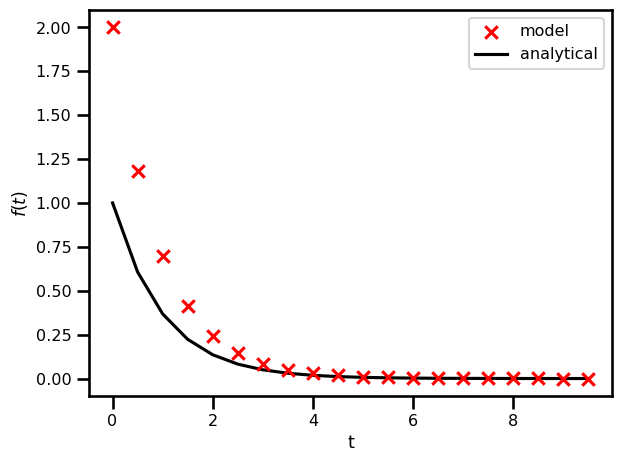

In [39]:
fig, ax = plt.subplots()

ax.scatter(sol.ts, sol.ys, label="model", marker="x", color="red")
ax.plot(sol.ts, np.exp(-sol.ts), label="analytical", color="black", zorder=-1)
ax.set(
    xlabel="t",
    ylabel="$f(t)$"
)
plt.legend()
plt.tight_layout()
plt.show()

### Controller

The library also has a controller which allows us to use solvers with adaptive step-sizes!

For this tutorial, we use the `Dopri5` which is the *Dormand-Prince 5(4)* (an explicit Runga-Kutta method).

For my MATLAB veterans, this is the equivalent of `ode45` that everyone used back in the day!

In [40]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

t0, t1 = 0, 10
dt = 0.1
saveat = SaveAt(ts=np.arange(t0, t1, dt*5))
solver = Dopri5()
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)

sol_ho = diffeqsolve(
    term, solver, 
    t0=t0, t1=t1, dt0=dt, y0=y0, 
    saveat=saveat,
    stepsize_controller=stepsize_controller
)

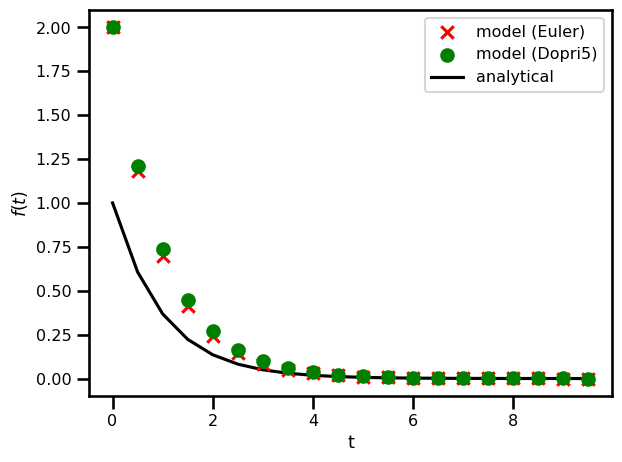

In [41]:
fig, ax = plt.subplots()

ax.scatter(sol.ts, sol.ys, label="model (Euler)", marker="x", color="red")
ax.scatter(sol_ho.ts, sol_ho.ys, label="model (Dopri5)", marker="o", color="green")
ax.plot(sol.ts, np.exp(-sol.ts), label="analytical", color="black", zorder=-1)
ax.set(
    xlabel="t",
    ylabel="$f(t)$"
)
plt.legend()
plt.tight_layout()
plt.show()

## Back to PDEs

Our problem is a time-dependent PDE. We actually did the method of lines (MOL) to solve it. We broke down the spatial derivative and offsetted everything to the RHS without writing the derivative. Now if we use the fundamental theorem of calculus like the ODE problem, we get:

$$
\begin{aligned}
u_{t} &= u(0) + \int_{0}^{t} f(u(\tau),\tau)d\tau \\
f(u(\tau),\tau) &:= \mathcal{RHS}[u](x,\tau) 
\end{aligned}
$$

whereby we solve this using the MOL. Essentially we solve a series of ODEs.

```{note}
For elliptical PDEs, the MOL is not so straightforward because of the higher order derivatives. So I've heard names like the MOL for transient PDEs.
```

In [42]:
from tqdm.notebook import tqdm

def vector_field(t, u, args):
    
    # apply bcs
    u = bc_fn(u)
    
    # calculate RHS
    rhs = rhs_fn(u, dx, c)
    
    # apply bcs
    # rhs = bc_fn(rhs)
    
    return rhs


In [43]:
import diffrax

# SPATIAL DISCRETIZATION
xmin = 0.0
xmax = 2.0
nx = 50
dx = xmax / (nx - 1)

# spatial grid
x_grid = np.linspace(xmin, xmax, nx)

# INITIAL CONDITION
u_init = init_u_fn(x_grid)

# TEMPORAL DISCRETIZATION
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)



# define ODE
term = diffrax.ODETerm(vector_field)

# TEMPORAL DISCRETIZATION
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, tmax, 10))

solver = diffrax.Euler()
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u_init,
    saveat=saveat,
    max_steps=None,
)





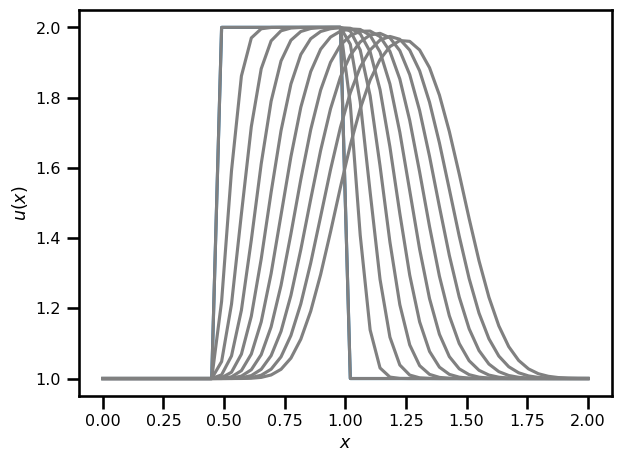

In [44]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init)
ax.plot(x_grid, sol.ys.T, color="gray", label="Euler")
ax.set(
    xlabel="$x$",
    ylabel="$u(x)$",
)
plt.tight_layout()
plt.show()

In [45]:
# define ODE
term = diffrax.ODETerm(vector_field)

# TEMPORAL DISCRETIZATION
saveat = diffrax.SaveAt(ts=jnp.linspace(t0, tmax, 10))

# TOLERANCES
rtol = 1e-10
atol = 1e-10
pcoeff = 0.3
icoeff = 0.4
dtmax = 0.001
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dtmax
)
solver = diffrax.Dopri5()
sol_2 = diffrax.diffeqsolve(
    term,
    solver,
    t0,
    tmax,
    dt,
    u_init,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

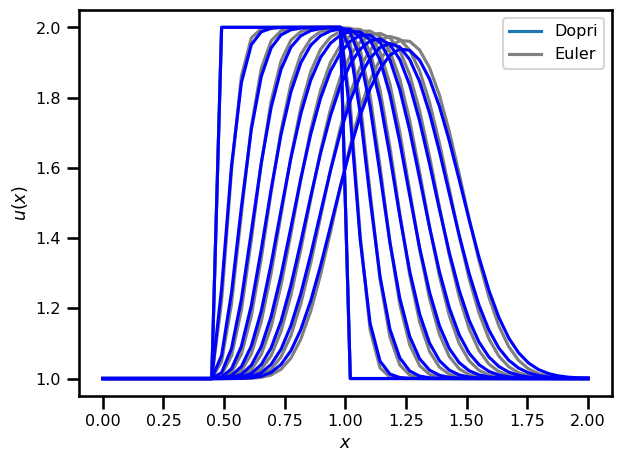

In [46]:
fig, ax = plt.subplots()
ax.plot(x_grid, u_init)
ax.plot(x_grid, sol.ys.T, color="gray", label="Euler")
ax.plot(x_grid, sol_2.ys.T, color="blue", label="Dopri5")
ax.set(
    xlabel="$x$",
    ylabel="$u(x)$",
)
plt.legend(["Dopri", "Euler"])
plt.tight_layout()
plt.show()

As we can see, there seems to be some dissipation. Could be the solver? Something to think about. But I think the most important thing is the fact that it is so easy to just try things without getting bogged down by the coding details!!

At least that is what I hope to convey!